In [1]:
from datasets.dtu import DTUDataset
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import os

torch.backends.cudnn.benchmark = True # this increases inference speed a little

# Load pretrained model

In [2]:
from models.mvsnet import CascadeMVSNet
from utils import load_ckpt
from inplace_abn import ABN
model = CascadeMVSNet(n_depths=[8,32,48],
                      interval_ratios=[1.0,2.0,4.0],
                      num_groups=1,
                      norm_act=ABN).cuda()
load_ckpt(model, 'ckpts/exp2/_ckpt_epoch_10.ckpt')
model.eval();

In [3]:
dataset = DTUDataset('/home/ubuntu/data/DTU/mvs_training/dtu/', 'test', n_views=5, depth_interval=2.65,
                     img_wh=None)

In [4]:
def decode_batch(batch):
    imgs = batch['imgs']
    proj_mats = batch['proj_mats']
    depths = batch['depths']
    masks = batch['masks']
    init_depth_min = batch['init_depth_min'].item()
    depth_interval = batch['depth_interval'].item()
    return imgs, proj_mats, depths, masks, init_depth_min, depth_interval

imgs, proj_mats, depths, masks, init_depth_min, depth_interval = decode_batch(dataset[80])
unpreprocess = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                           std=[1/0.229, 1/0.224, 1/0.225])

# Visualize an example depth

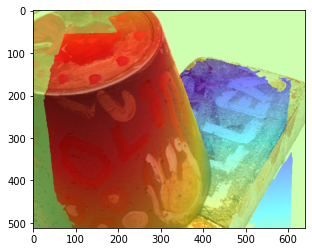

In [5]:
from utils import *
plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(depths['level_0']*masks['level_0']).permute(1,2,0), alpha=0.5)

# Do inference on this sample

In [6]:
t = time.time()
with torch.no_grad():
    results = model(imgs.unsqueeze(0).cuda(), proj_mats.unsqueeze(0).cuda(), init_depth_min, depth_interval)
    torch.cuda.synchronize()
print('inference time', time.time()-t)

inference time 0.7556626796722412


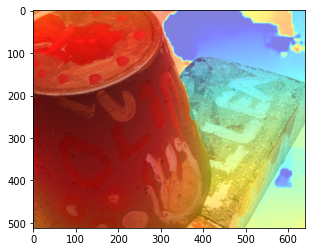

In [7]:
plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(results['depth_0'][0]).permute(1,2,0), alpha=0.5)

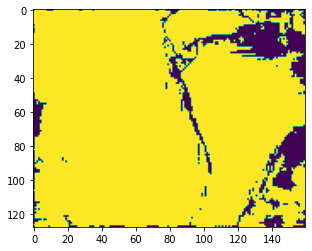

In [8]:
plt.imshow(results['confidence_2'][0].cpu().numpy()>0.999)

# Reference: show pixels whose absolute depth error is less than 2mm

acc_2mm : 0.9498143792152405


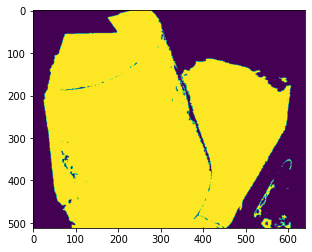

In [9]:
err2 = torch.abs(depths['level_0']-results['depth_0'].cpu())[0]<2
plt.imshow(err2);
print('acc_2mm :', ((err2.float()*masks['level_0']).sum()/masks['level_0'].sum()).item())